In [1]:
from wv_utils import reduce_dimensions, create_angle_matrix
from note_reader import get_notes_as_pitch_classes
from gensim.models import FastText
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

In [2]:
plt.rcParams["font.family"] = ["Times"]
SAVE_FIGS = True
UNK_TAG = "<UNK>"

In [3]:
file_list = glob.glob("data/txt/*.txt")

In [4]:
docs, counts = get_notes_as_pitch_classes(file_list)

In [5]:
pitches_sorted = counts.most_common()
pitches, pitch_counts = zip(*pitches_sorted)

In [6]:
THRESHOLD = 20

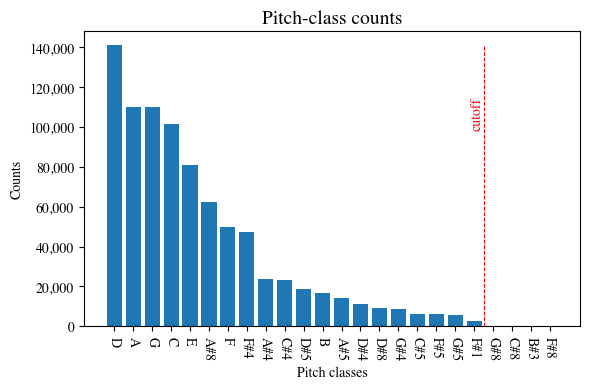

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.title("Pitch-class counts", fontdict={"fontsize": 14})
plt.xlabel("Pitch classes")
plt.xticks(rotation=-90)
plt.ylabel("Counts")
plt.gca().yaxis.set_major_formatter(
    plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.bar(pitches, pitch_counts)
plt.tight_layout()
plt.axvline(x=THRESHOLD-0.5, ymax=0.95, color="r",
            linestyle="--", linewidth=0.75)
plt.text(THRESHOLD-1.2, 100000, "cutoff", rotation=90, color="r")
plt.tight_layout()
plt.show()
if SAVE_FIGS:
    fig.savefig("results/overall_cutoff.pdf")

In [8]:
common_pitches = [x[0] for x in counts.most_common(THRESHOLD)]
common_docs = []
for doc in docs:
    common_doc = [x if x in common_pitches else UNK_TAG for x in doc]
    common_docs.append(common_doc)

# FastText model


In [9]:
# cb = callback()
ft_model = FastText(sentences=common_docs, vector_size=10,
                    epochs=500, window=5, seed=42)

In [10]:
wv = ft_model.wv
wv.most_similar(positive=["C", "A"], negative=["G"])  # D

[('D', 0.5787801742553711),
 ('A#8', 0.5608283877372742),
 ('C#5', 0.3819127082824707),
 ('E', 0.2773027718067169),
 ('B', 0.27589693665504456),
 ('F#1', 0.0690603107213974),
 ('C#4', -0.10227534919977188),
 ('A#4', -0.12984788417816162),
 ('F#5', -0.21033497154712677),
 ('A#5', -0.2165258228778839)]

In [11]:
angles_dict = create_angle_matrix(wv)
df = pd.DataFrame.from_dict(angles_dict)
if SAVE_FIGS:
    df.to_excel("results/angles.xlsx")

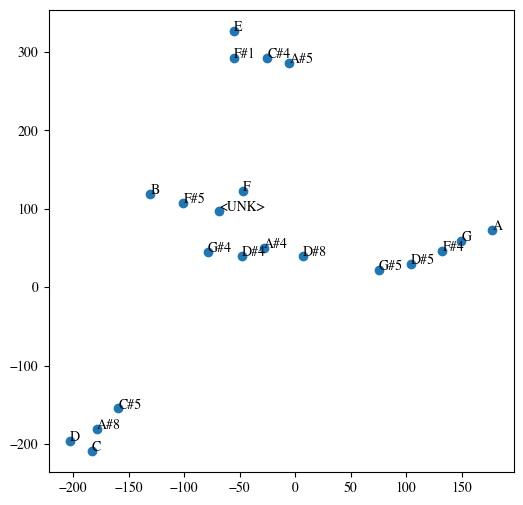

In [12]:
x_vals, y_vals, labels = reduce_dimensions(wv)
plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals)

for i in range(len(labels)):
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plt.show()

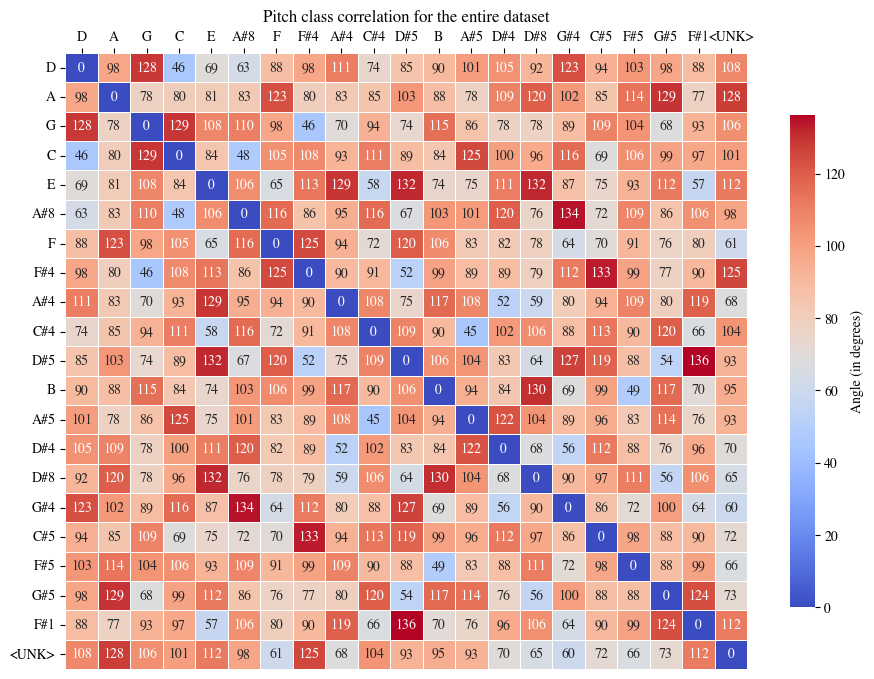

In [13]:
fig, ax = plt.subplots(figsize=(11, 8))
hm = sns.heatmap(df, cmap="coolwarm", annot=True, fmt=",.0f",
                 linewidths=0.5, cbar_kws={"shrink": 0.8})
hm.set(title="Pitch class correlation for the entire dataset")
ax.collections[0].colorbar.set_label("Angle (in degrees)")
ax.xaxis.tick_top()
plt.show()
if SAVE_FIGS:
    fig.savefig("results/overall_corr.pdf")